<a href="https://colab.research.google.com/github/ariegever/Thesis_SDM/blob/main/SDM_FIRST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='cryptic-yen-457008-p4')

In [ ]:
# Import libraries
import geemap

import geemap.colormaps as cm
import pandas as pd, geopandas as gpd
import numpy as np, matplotlib.pyplot as plt
import os, requests, math, random

from ipyleaflet import TileLayer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
from google.cloud import bigquery
import json

# Initialize the BigQuery client and explicitly set your project ID
client = bigquery.Client(project='rsc-cropmap-lzp')

# --- Your Customized SQL Query ---
sql = """
SELECT
    pred1 AS species,
    CAST(agri_year AS INT64) AS year,
    ST_AsGeoJSON(geometry) AS geometry
FROM
    `rsc-cropmap-lzp.published.Fused_Categories_Orchards`
WHERE
    pred1 IS NOT NULL
    AND pred1 = 'avocado'
"""
NAME = 'avocado'

df = client.query(sql).to_dataframe(create_bqstorage_client=False) # <-- THIS IS THE FIX

df.head(1)

,species,year,geometry
0,avocado,2018,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [35.27..."


In [ ]:
import geopandas as gpd
import shapely.geometry
import json

# Convert the GeoJSON text string from BigQuery into a real geometry object
df['geometry'] = df['geometry'].apply(lambda x: shapely.geometry.shape(json.loads(x)))

# Now, create the GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Let's check the first row and the geometry type
print(gdf.head(1))
print(f"Geometry type: {gdf.geom_type.unique()}")

   species  year                                           geometry
0  avocado  2018  POLYGON ((35.27774 30.74948, 35.27676 30.74977...
Geometry type: ['Polygon']


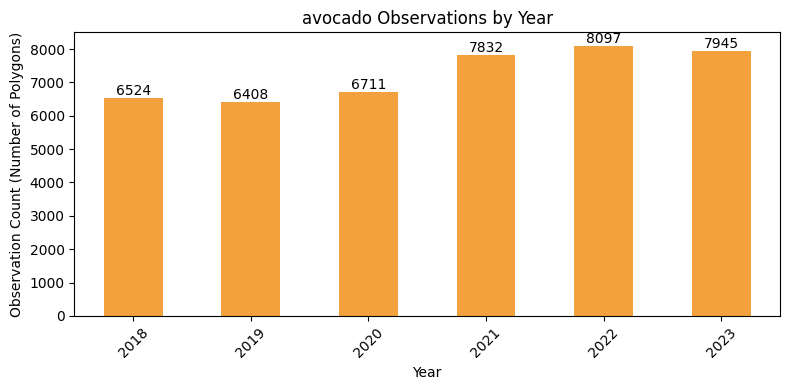

In [ ]:
def plot_year_counts(gdf, h_size=8):

    # Group by 'year' and get the size (count) for each
    # This creates a simple 1D Series (e.g., 2020: 500)
    statistics = gdf.groupby("year").size()

    # Create the bar plot
    plt.figure(figsize=(h_size, h_size - 4)) # Adjusted size
    ax = statistics.plot(kind='bar', color="#F2A13D") # Using one of the 'YlOrBr' colors

    # Add labels and title
    plt.title(f"{NAME} Observations by Year")
    plt.xlabel("Year")
    plt.ylabel("Observation Count (Number of Polygons)")
    plt.xticks(rotation=45) # Rotate x-axis labels to be readable

    # Add the count values on top of the bars
    for container in ax.containers:
        ax.bar_label(container)

    plt.tight_layout()
    plt.savefig("year_counts_plot.png")
    plt.show()

# Now, call your new function
plot_year_counts(gdf)

In [ ]:
import glob

# --- Step 1: Define the base filename ---
local_file_base = 'avocado_polygons'
local_shapefile_path = f'{local_file_base}.shp'

# --- Step 2: Save the GeoDataFrame to a Shapefile ---
# (This creates avocado_polygons.shp, .shx, .dbf, .prj, etc.)
print(f"Saving GeoDataFrame to {local_shapefile_path}...")
gdf.to_file(local_shapefile_path)

print("Shapefile components saved locally.")

Saving GeoDataFrame to avocado_polygons.shp...
Shapefile components saved locally.


In [ ]:
from google.colab import files

# --- Step 3: Find all component files ---
shapefile_components = glob.glob(f'{local_file_base}.*')
print(f"Found component files: {shapefile_components}")

# --- Step 4: Download each file ---
print("Starting download... Your browser will ask you to save each file.")
for file in shapefile_components:
    files.download(file)

print("All component file downloads initiated.")

Found component files: ['avocado_polygons.prj', 'avocado_polygons.cpg', 'avocado_polygons.shx', 'avocado_polygons.dbf', 'avocado_polygons.gpkg', 'avocado_polygons.shp', 'avocado_polygons.zip']
Starting download... Your browser will ask you to save each file.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All component file downloads initiated.


In [ ]:
# --- Load the Manually Uploaded Asset ---
grain_size = 1000
# 1. DEFINE the asset ID you just created
asset_id = 'projects/cryptic-yen-457008-p4/assets/avocado_polygons'

# 2. LOAD the polygons directly from your assets
data_raw = ee.FeatureCollection(asset_id)

# 3. DEFINE the remove_duplicates function (same as before)
def remove_duplicates(data, grain_size):
    random_raster = ee.Image.random().reproject("EPSG:4326", None, grain_size)
    rand_point_vals = random_raster.sampleRegions(
        collection=ee.FeatureCollection(data), geometries=True
    )
    return rand_point_vals.distinct("random")

# 4. RUN the function on your new server-side data_raw
print("Running remove_duplicates (this may take a moment)...")
data = remove_duplicates(data_raw, grain_size)

# 5. CHECK the sizes (this will now work)
print("Original data size (number of polygons):", data_raw.size().getInfo())
print("Final data size (number of 1km 'presence' cells):", data.size().getInfo())

Running remove_duplicates (this may take a moment)...
Original data size (number of polygons): 43517
Final data size (number of 1km 'presence' cells): 220


In [ ]:
# Visualization of geographic sampling bias before (blue) and after (red) preprocessing
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

# Add the random raster layer
random_raster = ee.Image.random().reproject("EPSG:4326", None, grain_size)
Map.addLayer(
    random_raster,
    {"min": 0, "max": 1, "palette": ["black", "white"], "opacity": 0.5},
    "Random Raster",
)

# Add the original data layer in blue
Map.addLayer(data_raw, {"color": "blue"}, "Original data")

# Add the final data layer in red
Map.addLayer(data, {"color": "red"}, "Final data")

# Set the center of the map to the coordinates
Map.centerObject(data, 10)
Map

Map(center=[32.4742545881713, 35.06913540898481], controls=(WidgetControl(options=['position', 'transparent_bg…

In [ ]:
# Define the AOI
LC_ASSET_ID = "projects/cryptic-yen-457008-p4/assets/LC_Data_v1"
print(f"Loading Land Cover asset: {LC_ASSET_ID}")
try:
    lc_image = ee.Image(LC_ASSET_ID)
except ee.EEException as e:
    print(f"Error loading LC Asset ID: {e}")
    print("Please double-check your LC_ASSET_ID path.")
    raise
aoi = lc_image.geometry().bounds().buffer(distance=10000, maxError=1000)

# Add the AOI to the map
outline = ee.Image().byte().paint(
    featureCollection=aoi, color=1, width=3)

Map.remove_layer("Random Raster")
Map.addLayer(outline, {'palette': 'FF0000'}, "AOI")
Map.centerObject(aoi, 6)
Map

Loading Land Cover asset: projects/cryptic-yen-457008-p4/assets/LC_Data_v1


Map(center=[31.401585016491246, 35.07193977445205], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# WorldClim V1 Bioclim
bio = ee.Image("WORLDCLIM/V1/BIO")
# NASA SRTM Digital Elevation 30m
terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))
# 3. Israel Soil Taxonomy
SOIL_ASSET_ID = "projects/cryptic-yen-457008-p4/assets/IsraelSoilTaxonomy"
soil_fc = ee.FeatureCollection(SOIL_ASSET_ID)
# A. Get a list of all unique soil types names, sorted alphabetically
unique_types = soil_fc.aggregate_array('OrderST').distinct().sort()

def string_to_int(feature):
    val = feature.get('OrderST')
    # indexOf returns the position in the list (an integer)
    index = unique_types.indexOf(val)
    return feature.set('OrderST_CODE', index)

# C. Apply the conversion to the feature collection
soil_fc_numbered = soil_fc.map(string_to_int)

# D. Print the key so you know which number equals which soil
mapping_dict = ee.Dictionary.fromLists(unique_types, ee.List.sequence(0, unique_types.size().subtract(1)))
print(mapping_dict.getInfo())

# E. Rasterize using the NEW numeric column
soil_image = soil_fc_numbered.reduceToImage(
    properties=['OrderST_CODE'],
    reducer=ee.Reducer.first()
).rename('OrderST')
# Combine bands into a multi-band image
predictors = bio.addBands(terrain).addBands(soil_image)


# Mask out ocean pixels and clip to the area of interest
predictors = predictors.clip(aoi)

{'Alfisols': 0, 'Aridisols': 1, 'Entisols': 2, 'Histosols': 3, 'Inceptisols': 4, 'Mollisols': 5, 'Vertisols': 6}


In [ ]:
# Generate 5,000 random points
data_cor = predictors.sample(scale=grain_size, numPixels=5000, geometries=True)

# Extract predictor variable values
pvals = predictors.sampleRegions(collection=data_cor, scale=grain_size)

In [ ]:
# Converting predictor values from Earth Engine to a DataFrame
pvals_df = geemap.ee_to_df(pvals)
pvals_df.head(10)

,OrderST,aspect,bio01,bio02,bio03,bio04,bio05,bio06,bio07,bio08,...,bio13,bio14,bio15,bio16,bio17,bio18,bio19,elevation,hillshade,slope
0,0,86,129,84,33,6137,261,8,253,48,...,216,0,101,591,2,3,591,1427,168,4
1,0,278,104,78,30,6197,235,-17,252,23,...,212,0,99,581,2,3,581,1766,217,12
2,0,88,89,78,30,6254,221,-34,255,8,...,200,1,97,548,4,4,548,2060,151,9
3,0,271,118,81,32,6158,249,-3,252,36,...,211,0,100,579,1,2,579,1549,208,9
4,0,253,101,78,30,6203,232,-21,253,20,...,205,0,98,562,2,3,562,1941,209,10
5,0,165,101,79,31,6229,233,-21,254,20,...,203,0,99,557,2,3,557,1726,165,19
6,0,221,134,88,34,6140,269,12,257,53,...,202,0,102,551,1,2,551,1292,197,8
7,0,144,130,86,33,6162,264,7,257,48,...,200,0,101,548,1,2,548,1243,153,15
8,6,227,195,105,41,5545,330,74,256,123,...,166,0,106,410,0,2,410,257,188,3
9,6,165,198,106,41,5548,333,77,256,126,...,161,0,106,394,0,2,394,234,179,2


In [ ]:
# Displaying the columns
columns = pvals_df.columns
print(columns)

Index(['OrderST', 'aspect', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05',
       'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13',
       'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'elevation',
       'hillshade', 'slope'],
      dtype='object')


In [ ]:
def plot_correlation_heatmap(dataframe, h_size=10, show_labels=False):
    # Calculate Spearman correlation coefficients
    correlation_matrix = dataframe.corr(method="spearman")

    # Create a heatmap
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # Optionally display values on the heatmap
    if show_labels:
        for i in range(correlation_matrix.shape[0]):
            for j in range(correlation_matrix.shape[1]):
                plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                         ha='center', va='center', color='white', fontsize=8)

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables Correlation Matrix")
    plt.colorbar(label="Spearman Correlation")
    plt.savefig('correlation_heatmap_plot.png')
    plt.show()

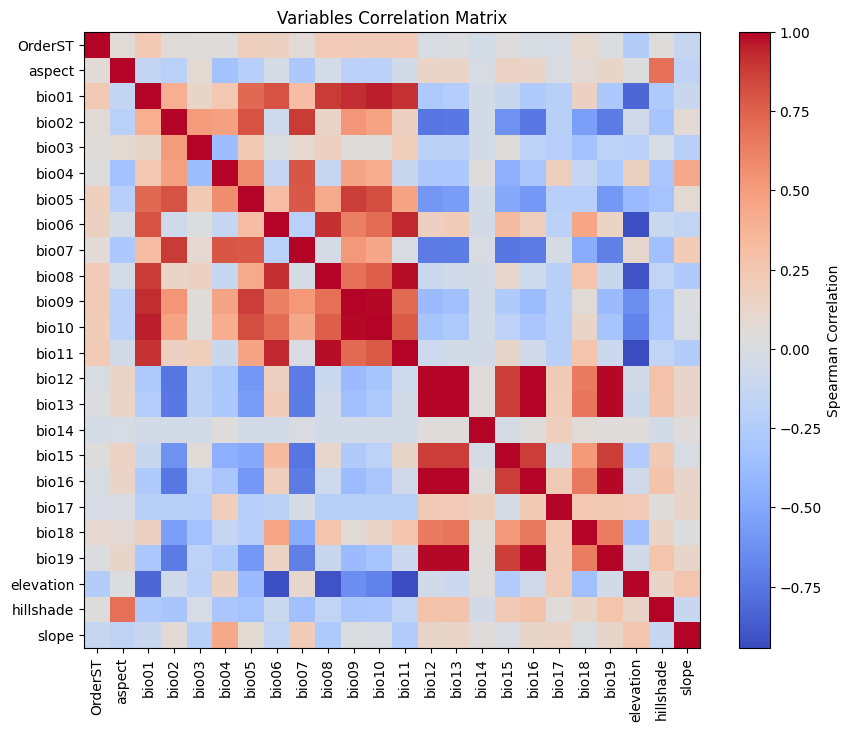

In [ ]:
# Plot the correlation heatmap of variables
plot_correlation_heatmap(pvals_df)

In [ ]:
# Filter variables based on Variance Inflation Factor (VIF)
## DONT RUN IT
def filter_variables_by_vif(dataframe, threshold=10):

    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]

    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [
            variance_inflation_factor(vif_data.values, i)
            for i in range(vif_data.shape[1])
        ]

        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)

        if max_vif < threshold:
            break

        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")

        del remaining_columns[max_vif_index]

    filtered_data = dataframe[remaining_columns]
    bands = filtered_data.columns.tolist()
    print("Bands:", bands)

    return filtered_data, bands
filtered_pvals_df, bands = filter_variables_by_vif(pvals_df)

In [ ]:
bands = ['OrderST', 'aspect', 'elevation', 'slope', 'bio01', 'bio12']
filtered_pvals_df = pvals_df[bands]

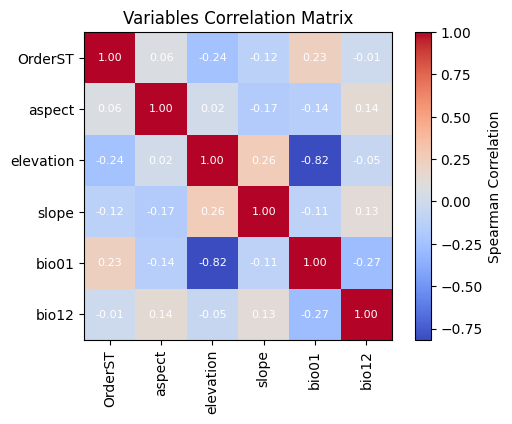

In [ ]:
# Variable Selection Based on VIF
predictors = predictors.select(bands)

# Plot the correlation heatmap of variables
plot_correlation_heatmap(filtered_pvals_df, h_size=6, show_labels=True)

In [ ]:
# Randomly select 100 locations for occurrence
pvals = predictors.sampleRegions(
    collection=data.randomColumn().sort('random').limit(100),
    properties=[],
    scale=grain_size
)

# Perform k-means clustering
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(pvals)

cl_result = predictors.cluster(clusterer)

# Get cluster ID for locations similar to occurrence
cl_id = cl_result.sampleRegions(
    collection=data.randomColumn().sort('random').limit(200),
    properties=[],
    scale=grain_size
)

# Define non-occurrence areas in dissimilar clusters
cl_id = ee.FeatureCollection(cl_id).reduceColumns(ee.Reducer.mode(),['cluster'])
cl_id = ee.Number(cl_id.get('mode')).subtract(1).abs()
cl_mask = cl_result.select(['cluster']).eq(cl_id)

In [ ]:
# Presence location mask
presence_mask = data.reduceToImage(properties=['random'],
reducer=ee.Reducer.first()
).reproject('EPSG:4326', None,
            grain_size).mask().neq(1).selfMask()

# Masking presence locations in non-occurrence areas and clipping to AOI
area_for_pa = presence_mask.updateMask(cl_mask).clip(aoi)

# Area for Pseudo-absence
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.addLayer(area_for_pa, {'palette': 'black'}, 'AreaForPA')
Map.centerObject(aoi, 6)
Map

Map(center=[31.401585016491246, 35.07193977445205], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
Scale = 50000 # 50km grid cells

raw_grid = aoi.coveringGrid(scale=Scale, proj='EPSG:4326')


grid = raw_grid.filter(ee.Filter.bounds(aoi))
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
grid_style = {'color': 'black', 'fillColor': '00000000', 'width': 2}
Map.addLayer(grid.style(**grid_style), {}, "Grid for spatial block cross validation")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(aoi, 6)
Map

Map(center=[31.401585016491246, 35.07193977445205], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
def sdm(x):
    seed = ee.Number(x)

    # Random block division for training and validation
    rand_blk = ee.FeatureCollection(grid).randomColumn(seed=seed).sort("random")
    training_grid = rand_blk.filter(ee.Filter.lt("random", split))  # Grid for training
    testing_grid = rand_blk.filter(ee.Filter.gte("random", split))  # Grid for testing

    # Presence points
    presence_points = ee.FeatureCollection(data)
    presence_points = presence_points.map(lambda feature: feature.set("PresAbs", 1))
    tr_presence_points = presence_points.filter(
        ee.Filter.bounds(training_grid)
    )  # Presence points for training
    te_presence_points = presence_points.filter(
        ee.Filter.bounds(testing_grid)
    )  # Presence points for testing

    # Pseudo-absence points for training
    tr_pseudo_abs_points = area_for_pa.sample(
        region=training_grid,
        scale=grain_size,
        numPixels=tr_presence_points.size().add(300),
        seed=seed,
        geometries=True,
    )
    # Same number of pseudo-absence points as presence points for training
    tr_pseudo_abs_points = (
        tr_pseudo_abs_points.randomColumn()
        .sort("random")
        .limit(ee.Number(tr_presence_points.size()))
    )
    tr_pseudo_abs_points = tr_pseudo_abs_points.map(lambda feature: feature.set("PresAbs", 0))

    te_pseudo_abs_points = area_for_pa.sample(
        region=testing_grid,
        scale=grain_size,
        numPixels=te_presence_points.size().add(100),
        seed=seed,
        geometries=True,
    )
    # Same number of pseudo-absence points as presence points for testing
    te_pseudo_abs_points = (
        te_pseudo_abs_points.randomColumn()
        .sort("random")
        .limit(ee.Number(te_presence_points.size()))
    )
    te_pseudo_abs_points = te_pseudo_abs_points.map(lambda feature: feature.set("PresAbs", 0))

    # Merge training and pseudo-absence points
    training_partition = tr_presence_points.merge(tr_pseudo_abs_points)
    testing_partition = te_presence_points.merge(te_pseudo_abs_points)

    # Extract predictor variable values at training points
    train_pvals = predictors.sampleRegions(
        collection=training_partition,
        properties=["PresAbs"],
        scale=grain_size,
        geometries=True,
    )

    # Random Forest classifier
    classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=250,
        variablesPerSplit=None,
        minLeafPopulation=10,
        bagFraction=0.5,
        maxNodes=None,
        seed=seed,
    )
    # Presence probability: Habitat suitability map
    classifier_pr = classifier.setOutputMode("PROBABILITY").train(
        train_pvals, "PresAbs", bands
    )
    classified_img_pr = predictors.select(bands).classify(classifier_pr)

    # Binary presence/absence map: Potential distribution map
    classifier_bin = classifier.setOutputMode("CLASSIFICATION").train(
        train_pvals, "PresAbs", bands
    )
    classified_img_bin = predictors.select(bands).classify(classifier_bin)

    return [
        classified_img_pr,
        classified_img_bin,
        training_partition,
        testing_partition,
    ], classifier_pr

In [ ]:
split = 0.7
numiter = 5

# Random Seed
runif = lambda length: [random.randint(1, 1000) for _ in range(length)]
items = runif(numiter)

# Fixed seed
# items = [287, 288, 553, 226, 151, 255, 902, 267, 419, 538]

In [ ]:
results_list = [] # Initialize SDM results list
importances_list = [] # Initialize variable importance list

for item in items:
    result, trained = sdm(item)
    # Accumulate SDM results into the list
    results_list.extend(result)

    # Accumulate variable importance into the list
    importance = ee.Dictionary(trained.explain()).get('importance')
    importances_list.extend(importance.getInfo().items())

# Flatten the SDM results list
results = ee.List(results_list).flatten()

In [ ]:
# Habitat suitability map
images = ee.List.sequence(
    0, ee.Number(numiter).multiply(4).subtract(1), 4).map(
    lambda x: results.get(x))
model_average = ee.ImageCollection.fromImages(images).mean()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'}, basemap='Esri.WorldImagery')

vis_params = {
    'min': 0,
    'max': 1,
    'palette': cm.palettes.viridis_r}
Map.addLayer(model_average, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability",
                 orientation="horizontal",
                 layer_name="Habitat suitability")
Map.addLayer(data, {'color':'red'}, 'Presence')
Map.centerObject(aoi, 6)
Map

Map(center=[31.401585016491246, 35.07193977445205], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Potential distribution map
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).subtract(1), 4).map(
    lambda x: results.get(x)
)
distribution_map = ee.ImageCollection.fromImages(images2).mode()

Map = geemap.Map(
    layout={"height": "400px", "width": "800px"}, basemap="Esri.WorldImagery"
)

vis_params = {"min": 0, "max": 1, "palette": ["white", "green"]}
Map.addLayer(distribution_map, vis_params, "Potential distribution")
Map.addLayer(data, {"color": "red"}, "Presence")
Map.add_colorbar(
    vis_params,
    label="Potential distribution",
    discrete=True,
    orientation="horizontal",
    layer_name="Potential distribution",
)
Map.centerObject(data.geometry(), 6)
Map

Map(center=[32.4742545881713, 35.06913540898481], controls=(WidgetControl(options=['position', 'transparent_bg…

In [ ]:
def plot_variable_importance(importances_list):
    # Extract each variable importance value into a list
    variables = [item[0] for item in importances_list]
    importances = [item[1] for item in importances_list]

    # Calculate the average importance for each variable
    average_importances = {}
    for variable in set(variables):
        indices = [i for i, var in enumerate(variables) if var == variable]
        average_importance = np.mean([importances[i] for i in indices])
        average_importances[variable] = average_importance

    # Sort the importances in descending order of importance
    sorted_importances = sorted(average_importances.items(),
                                key=lambda x: x[1], reverse=False)
    variables = [item[0] for item in sorted_importances]
    avg_importances = [item[1] for item in sorted_importances]

    # Adjust the graph size
    plt.figure(figsize=(8, 4))

    # Plot the average importance as a horizontal bar chart
    plt.barh(variables, avg_importances)
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.title('Average Variable Importance')

    # Display values above the bars
    for i, v in enumerate(avg_importances):
        plt.text(v + 0.02, i, f"{v:.2f}", va='center')

    # Adjust the x-axis range
    plt.xlim(0, max(avg_importances) + 5)  # Adjust to the desired range

    plt.tight_layout()
    plt.savefig('variable_importance.png')
    plt.show()

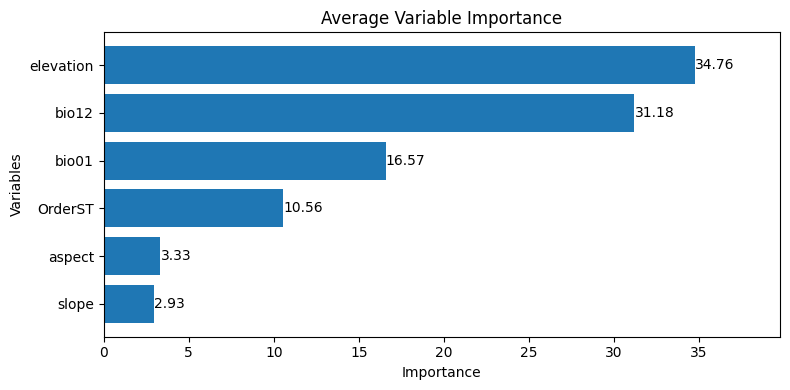

In [ ]:
plot_variable_importance(importances_list)

In [ ]:
def print_pres_abs_sizes(TestingDatasets, numiter):
    # Check and print the sizes of presence and pseudo-absence coordinates
    def get_pres_abs_size(x):
        fc = ee.FeatureCollection(TestingDatasets.get(x))
        presence_size = fc.filter(ee.Filter.eq("PresAbs", 1)).size()
        pseudo_absence_size = fc.filter(ee.Filter.eq("PresAbs", 0)).size()
        return ee.List([presence_size, pseudo_absence_size])

    sizes_info = (
        ee.List.sequence(0, ee.Number(numiter).subtract(1), 1)
        .map(get_pres_abs_size)
        .getInfo()
    )

    for i, sizes in enumerate(sizes_info):
        presence_size = sizes[0]
        pseudo_absence_size = sizes[1]
        print(
            f"Iteration {i + 1}: Presence Size = {presence_size}, Pseudo-absence Size = {pseudo_absence_size}"
        )

In [ ]:
# Extracting the Testing Datasets
testing_datasets = ee.List.sequence(
    3, ee.Number(numiter).multiply(4).subtract(1), 4
).map(lambda x: results.get(x))

print_pres_abs_sizes(testing_datasets, numiter)

Iteration 1: Presence Size = 57, Pseudo-absence Size = 36
Iteration 2: Presence Size = 32, Pseudo-absence Size = 25
Iteration 3: Presence Size = 36, Pseudo-absence Size = 27
Iteration 4: Presence Size = 39, Pseudo-absence Size = 28
Iteration 5: Presence Size = 66, Pseudo-absence Size = 26


In [ ]:
import pandas as pd
import ee

# 1. Optimize the extraction function
def get_acc(hsm, t_data, grain_size):
    # Added tileScale=4 (or 8/16) to handle memory better during sampling
    pr_prob_vals = hsm.sampleRegions(
        collection=t_data,
        properties=["PresAbs"],
        scale=grain_size,
        tileScale=4
    )

    # We will return the raw collection to process cuts in the main loop
    # or keep the logic here if the collection isn't massive.
    # For this specific error, the bottleneck is likely the volume of 'seq' mapping.

    seq = ee.List.sequence(start=0, end=1, count=25)

    def calculate_metrics(cutoff):
        # ... (Your existing logic remains mostly the same) ...
        pres = pr_prob_vals.filterMetadata("PresAbs", "equals", 1)
        tp = ee.Number(pres.filterMetadata("classification", "greater_than", cutoff).size())
        tpr = tp.divide(pres.size())

        abs_ = pr_prob_vals.filterMetadata("PresAbs", "equals", 0) # Renamed 'abs' to 'abs_' to avoid python keyword conflict
        fn = ee.Number(pres.filterMetadata("classification", "less_than", cutoff).size())
        tn = ee.Number(abs_.filterMetadata("classification", "less_than", cutoff).size())
        tnr = tn.divide(abs_.size())
        fp = ee.Number(abs_.filterMetadata("classification", "greater_than", cutoff).size())
        fpr = fp.divide(abs_.size())
        precision = tp.divide(tp.add(fp))
        sumss = tpr.add(tnr)

        return ee.Feature(None, {
            "cutoff": cutoff,
            "TPR": tpr,
            "FPR": fpr,
            "Precision": precision
        })

    return ee.FeatureCollection(seq.map(calculate_metrics))

In [ ]:
import pandas as pd
import ee
import gc
from sklearn.metrics import auc

# ---------------------------------------------------------
# 1. Optimized Extraction Function (Updated tileScale)
# ---------------------------------------------------------
def get_acc(hsm, t_data, grain_size):
    # tileScale=16 is aggressive against "Memory Limit Exceeded"
    # It makes processing slightly slower but much more stable.
    pr_prob_vals = hsm.sampleRegions(
        collection=t_data,
        properties=["PresAbs"],
        scale=grain_size,
        tileScale=16
    )

    # Sequence of cutoffs
    seq = ee.List.sequence(start=0, end=1, count=25)

    def calculate_metrics(cutoff):
        pres = pr_prob_vals.filterMetadata("PresAbs", "equals", 1)
        abs_ = pr_prob_vals.filterMetadata("PresAbs", "equals", 0)

        # True Positives
        tp = ee.Number(pres.filterMetadata("classification", "greater_than", cutoff).size())
        # True Positive Rate (Recall)
        tpr = tp.divide(pres.size())

        # False Negatives & True Negatives
        tn = ee.Number(abs_.filterMetadata("classification", "less_than", cutoff).size())
        tnr = tn.divide(abs_.size())

        # False Positives
        fp = ee.Number(abs_.filterMetadata("classification", "greater_than", cutoff).size())
        # False Positive Rate
        fpr = fp.divide(abs_.size())

        # Precision (Safe division to avoid div by zero)
        precision = tp.divide(tp.add(fp).max(1))

        return ee.Feature(None, {
            "cutoff": cutoff,
            "TPR": tpr,
            "FPR": fpr,
            "Precision": precision
        })

    return ee.FeatureCollection(seq.map(calculate_metrics))

# ---------------------------------------------------------
# 2. Main Processing Loop (With Memory Cleanup)
# ---------------------------------------------------------
def calculate_and_print_auc_metrics(images, testing_datasets, grain_size, numiter):
    auc_metrics_list = []

    print(f"Starting processing for {numiter} iterations on High-RAM...")

    for x in range(numiter):
        try:
            print(f"Processing iteration {x + 1}...")

            # 1. Get specific image and dataset for this iteration
            hsm = ee.Image(images.get(x))
            t_data = ee.FeatureCollection(testing_datasets.get(x))

            # 2. Get accuracy metrics from GEE
            acc_fc = get_acc(hsm, t_data, grain_size)

            # 3. Fetch lists to Client-Side (Python)
            # We pull FPR, TPR, Precision lists.
            data_arrays = acc_fc.reduceColumns(
                reducer=ee.Reducer.toList().repeat(3),
                selectors=["FPR", "TPR", "Precision"]
            )

            results = data_arrays.get('list').getInfo()

            # 4. Process in Python
            fpr_vals = results[0]
            tpr_vals = results[1]
            prec_vals = results[2]

            # --- SKLEARN AUC CALCULATION ---
            # Scikit-learn requires x-axis to be monotonic increasing.
            # Since cutoffs go 0->1, FPR usually goes 1->0 (decreasing).
            # We must sort by the x-axis variable before calculating AUC.

            # Calculate AUC-ROC (Sort by FPR)
            if len(fpr_vals) > 1:
                sorted_roc = sorted(zip(fpr_vals, tpr_vals))
                fpr_sorted, tpr_sorted = zip(*sorted_roc)
                auc_roc = auc(fpr_sorted, tpr_sorted)
            else:
                auc_roc = 0

            # Calculate AUC-PR (Sort by Recall/TPR)
            if len(tpr_vals) > 1:
                sorted_pr = sorted(zip(tpr_vals, prec_vals))
                tpr_sorted_pr, prec_sorted = zip(*sorted_pr)
                auc_pr = auc(tpr_sorted_pr, prec_sorted)
            else:
                auc_pr = 0

            print(f"   > Iteration {x+1} Success: ROC={auc_roc:.4f}, PR={auc_pr:.4f}")
            auc_metrics_list.append((auc_roc, auc_pr))

            # 5. CLEANUP MEMORY
            del hsm, t_data, acc_fc, results, fpr_vals, tpr_vals, prec_vals
            gc.collect()

        except Exception as e:
            print(f"   > Error in iteration {x + 1}: {e}")
            auc_metrics_list.append((None, None))

    # --- Results Output ---
    df = pd.DataFrame(auc_metrics_list, columns=["AUC-ROC", "AUC-PR"])
    df.index = [f"Iteration {i + 1}" for i in range(len(df))]

    # Save immediately so you don't lose data if the next cell crashes
    df.to_csv("auc_metrics_safe.csv", index_label="Iteration")

    print("\n" + "="*30)
    print(df)
    print("="*30)

    # Calculate stats
    df_clean = df.dropna()
    if not df_clean.empty:
        mean_auc_roc = df_clean["AUC-ROC"].mean()
        std_auc_roc = df_clean["AUC-ROC"].std()
        mean_auc_pr = df_clean["AUC-PR"].mean()
        std_auc_pr = df_clean["AUC-PR"].std()

        print(f"Mean AUC-ROC = {mean_auc_roc:.4f} ± {std_auc_roc:.4f}")
        print(f"Mean AUC-PR = {mean_auc_pr:.4f} ± {std_auc_pr:.4f}")
    else:
        print("No successful iterations to average.")

# ---------------------------------------------------------
# 3. Execute
# ---------------------------------------------------------
# Only run this if your variables (images, testing_datasets) exist in memory
calculate_and_print_auc_metrics(images, testing_datasets, grain_size, numiter)

Starting processing for 5 iterations on High-RAM...
Processing iteration 1...


KeyboardInterrupt: 

In [ ]:
%%time

# Calculate AUC-ROC and AUC-PR
calculate_and_print_auc_metrics(images, testing_datasets, grain_size, numiter)

Starting processing for 5 iterations...
Processing iteration 1...
Error in iteration 1: User memory limit exceeded.
Processing iteration 2...
Error in iteration 2: User memory limit exceeded.
Processing iteration 3...
Error in iteration 3: User memory limit exceeded.
Processing iteration 4...
Error in iteration 4: User memory limit exceeded.
Processing iteration 5...
Error in iteration 5: User memory limit exceeded.
            AUC-ROC AUC-PR
Iteration 1    None   None
Iteration 2    None   None
Iteration 3    None   None
Iteration 4    None   None
Iteration 5    None   None
Mean AUC-ROC = nan ± nan
Mean AUC-PR = nan ± nan
CPU times: user 228 ms, sys: 45.8 ms, total: 273 ms
Wall time: 29min 3s


In [ ]:
# --- Export 1: Habitat Suitability Map (model_average) ---

# Define the export task
task1 = ee.batch.Export.image.toDrive(
    image=model_average,  # The image to export
    description='export_avocado_suitability_map', # Task name in the Tasks tab
    folder='GEE_Exports',  # Folder in your Google Drive
    fileNamePrefix='avocado_habitat_suitability', # File name
    scale=grain_size,     # Use the same 1km resolution (1000)
    region=aoi,           # Use the same Area of Interest
    maxPixels=1e13        # Allow for a large export
)

# Start the task
task1.start()

print("Started task 1: 'export_avocado_suitability_map'")

Started task 1: 'export_avocado_suitability_map'


In [ ]:
# --- Export 2: Potential Distribution Map (distribution_map) ---

# Define the export task
task2 = ee.batch.Export.image.toDrive(
    image=distribution_map, # The image to export
    description='export_avocado_distribution_map', # Task name
    folder='GEE_Exports',   # Folder in your Google Drive
    fileNamePrefix='avocado_potential_distribution', # File name
    scale=grain_size,      # Use the same 1km resolution (1000)
    region=aoi,            # Use the same Area of Interest
    maxPixels=1e13         # Allow for a large export
)

# Start the task
task2.start()

print("Started task 2: 'export_avocado_distribution_map'")

Started task 2: 'export_avocado_distribution_map'


In [ ]:
import ee

bands = ['OrderST', 'aspect', 'elevation', 'slope', 'bio01', 'bio12']

# 2. Re-train the classifier with PROBABILITY mode enabled
# Note: We use the same 'final_pvals' variable you created in your training step.
# If you lost 'final_pvals', you need to re-run the "Prepare ALL points" block from your training script.

final_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=250,
    minLeafPopulation=10,
    bagFraction=0.5,
    seed=42
).setOutputMode('PROBABILITY') \
 .train(final_pvals, "PresAbs", bands)

# 3. Overwrite the Asset
asset_id = 'projects/cryptic-yen-457008-p4/assets/avocado_final_model'

task_save_model = ee.batch.Export.classifier.toAsset(
    classifier=final_classifier,
    description='Save_Final_Model_With_Probability',
    assetId=asset_id
)

task_save_model.start()
print(f"Export task started! \nIMPORTANT: You must wait for this task to finish in the GEE 'Tasks' tab before running the prediction code.")

Export task started! 
IMPORTANT: You must wait for this task to finish in the GEE 'Tasks' tab before running the prediction code.


In [ ]:
import ee

# 1. Define the bands explicitly to match your manual selection
bands = ['OrderST', 'aspect', 'elevation', 'slope', 'bio01', 'bio12']

# 2. Re-train the classifier in DEFAULT mode (Classification)
# Note: We do NOT use .setOutputMode('PROBABILITY') here.
# We ensure 'final_pvals' exists. If you lost it, re-run the "Prepare ALL points" block.
final_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=250,
    minLeafPopulation=10,
    bagFraction=0.5,
    seed=42
).train(final_pvals, "PresAbs", bands)

# 3. Overwrite the Asset
asset_id = 'projects/cryptic-yen-457008-p4/assets/avocado_final_model'

task_save_model = ee.batch.Export.classifier.toAsset(
    classifier=final_classifier,
    description='Save_Final_Model_Fixed', # Changed name to track it
    assetId=asset_id
)

task_save_model.start()
print(f"Export task 'Save_Final_Model_Fixed' started.\nPlease wait for it to complete in the Tasks tab.")

Export task 'Save_Final_Model_Fixed' started.
Please wait for it to complete in the Tasks tab.


In [ ]:
import ee
import geemap

# Initialize
try:
    ee.Initialize(project='cryptic-yen-457008-p4')
except:
    ee.Authenticate()
    ee.Initialize(project='cryptic-yen-457008-p4')

# =========================================================
# 1. SETUP: PREDICTORS & DATA
# =========================================================
bands = ['OrderST', 'aspect', 'elevation', 'slope', 'bio01', 'bio12']

# Load Static Variables (Unmasked to prevent holes)
terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003")).unmask()
elevation = terrain.select(['elevation'])
slope = terrain.select(['slope'])
aspect = terrain.select(['aspect'])

# Soil
soil_fc = ee.FeatureCollection("projects/cryptic-yen-457008-p4/assets/IsraelSoilTaxonomy")
u_types = soil_fc.aggregate_array('OrderST').distinct().sort()
soil_img = soil_fc.map(lambda f: f.set('Code', u_types.indexOf(f.get('OrderST')))) \
    .reduceToImage(['Code'], ee.Reducer.first()).rename('OrderST').unmask(-1)

# Current Climate (for training context)
bio_curr = ee.Image("WORLDCLIM/V1/BIO").select(['bio01', 'bio12']).unmask()
current_stack = bio_curr.addBands([soil_img, elevation, slope, aspect])

# Prepare Training Points (Use ALL data for the best future prediction)
pres = data.map(lambda f: f.set("PresAbs", 1))
# Generate pseudo-absences
aoi = soil_fc.geometry().bounds()
abs_ = current_stack.sample(region=aoi, scale=1000, numPixels=pres.size().add(200), geometries=True) \
    .randomColumn().sort('random').limit(pres.size()).map(lambda f: f.set("PresAbs", 0))

final_training = current_stack.select(bands).sampleRegions(
    collection=pres.merge(abs_), properties=["PresAbs"], scale=1000, tileScale=16
)

# =========================================================
# 2. TRAIN MASTER MODEL (In-Memory)
# =========================================================
print("Training Final Master Model (100% Data)...")
master_rf = ee.Classifier.smileRandomForest(250).train(final_training, "PresAbs", bands)
# Set to Probability Mode for the map gradient
rf_prob = master_rf.setOutputMode('MULTIPROBABILITY')

# =========================================================
# 3. PREDICT FUTURE (RCP 4.5 & 8.5)
# =========================================================
def get_future_map(scenario):
    # NEX-GDDP 2050
    nex = ee.ImageCollection("NASA/NEX-GDDP") \
        .filter(ee.Filter.date('2050-01-01', '2050-12-31')) \
        .filter(ee.Filter.eq('scenario', scenario)) \
        .filter(ee.Filter.eq('model', 'ACCESS1-0')) # You can change the GCM model here

    def convert(img):
        # Fix Units: Precip Flux -> Total mm, Kelvin -> Celsius
        pr = img.select('pr').multiply(86400).rename('precip_mm')
        tm = img.select('tasmin').add(img.select('tasmax')).divide(2).subtract(273.15).rename('tmean_c')
        return img.addBands([pr, tm])

    # Aggregating to Annual Mean (Bio01) and Annual Sum (Bio12)
    nex_agg = nex.map(convert).map(lambda i: i.resample('bilinear').reproject('EPSG:4326', None, 1000))
    bio01 = nex_agg.select('tmean_c').mean().rename('bio01')
    bio12 = nex_agg.select('precip_mm').sum().rename('bio12')

    future_stack = ee.Image.cat([bio01, bio12, soil_img, elevation, slope, aspect])

    # Predict and get Probability of Presence (Index 1)
    return future_stack.select(bands).classify(rf_prob).arrayGet([1])

print("Predicting RCP 4.5...")
map_rcp45 = get_future_map('rcp45')

print("Predicting RCP 8.5...")
map_rcp85 = get_future_map('rcp85')

diff_map = map_rcp85.subtract(map_rcp45)

# =========================================================
# 4. VISUALIZATION (Fixed to look better)
# =========================================================
Map = geemap.Map(layout={'height':'600px', 'width':'100%'})

# Updated Palette: Transparent -> Yellow -> Green -> Dark Green
# This prevents the map from looking "flat" green
vis_suit = {"min": 0, "max": 1, "palette": ["ffffff", "cecece", "fcd163", "66a000", "204200"]}

# Difference: Red (Loss) -> White (Same) -> Blue (Gain)
vis_diff = {"min": -0.3, "max": 0.3, "palette": ["d7191c", "ffffff", "2c7bb6"]}

Map.addLayer(model_average, vis_suit, "Current Suitability (Your Loop)")
Map.addLayer(map_rcp45.clip(aoi), vis_suit, "Future Suitability 2050 (RCP 4.5)")
Map.addLayer(map_rcp85.clip(aoi), vis_suit, "Future Suitability 2050 (RCP 8.5)")
Map.addLayer(diff_map.clip(aoi), vis_diff, "Difference (Red=Worse in 8.5)")

Map.centerObject(aoi, 7)
Map.add_colorbar(vis_suit, label="Suitability Probability", layer_name="Future Suitability")
Map.add_colorbar(vis_diff, label="Change (Negative=Loss)", layer_name="Difference")

print("Maps generated.")
Map

Training Final Master Model (100% Data)...
Predicting RCP 4.5...
Predicting RCP 8.5...
Maps generated.


Map(center=[31.400074006293078, 35.08043162863919], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# =========================================================
# 5. EXPORT ALL MAPS TO GOOGLE DRIVE
# =========================================================

# Shared configuration for 1km resolution
export_config = {
    'scale': 1000,
    'region': aoi,
    'maxPixels': 1e13,
    'crs': 'EPSG:4326',
    'folder': 'GEE_Exports'  # Creates this folder in your Drive
}

print("--- Starting Export Tasks ---")

# 1. Export CURRENT Suitability (Baseline)
# This is the 'model_average' created from your 5-iteration loop
task_current = ee.batch.Export.image.toDrive(
    image=model_average,
    description='Export_Avocado_Current_Baseline',
    fileNamePrefix='Avocado_Suitability_Current_Baseline',
    **export_config
)
task_current.start()
print("✅ Started: Current Baseline Suitability")

# 2. Export RCP 4.5 (2050)
task_rcp45 = ee.batch.Export.image.toDrive(
    image=map_rcp45,
    description='Export_Avocado_RCP45_2050',
    fileNamePrefix='Avocado_Suitability_RCP45_2050',
    **export_config
)
task_rcp45.start()
print("✅ Started: RCP 4.5 (2050)")

# 3. Export RCP 8.5 (2050)
task_rcp85 = ee.batch.Export.image.toDrive(
    image=map_rcp85,
    description='Export_Avocado_RCP85_2050',
    fileNamePrefix='Avocado_Suitability_RCP85_2050',
    **export_config
)
task_rcp85.start()
print("✅ Started: RCP 8.5 (2050)")

# 4. Export DIFFERENCE Map (RCP 8.5 - RCP 4.5)
task_diff = ee.batch.Export.image.toDrive(
    image=diff_map,
    description='Export_Avocado_Diff_RCP85_vs_RCP45',
    fileNamePrefix='Avocado_Difference_RCP85_vs_RCP45',
    **export_config
)
task_diff.start()
print("✅ Started: Difference Map")

print("\nAll 4 tasks submitted. Please check the 'Tasks' tab.")

--- Starting Export Tasks ---
✅ Started: Current Baseline Suitability
✅ Started: RCP 4.5 (2050)
✅ Started: RCP 8.5 (2050)
✅ Started: Difference Map

All 4 tasks submitted. Please check the 'Tasks' tab.
